# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

preprocess.x_train.std()

0.99589320646770185

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.001
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
        with tf.variable_scope("Layer_Dense_Hidden"):
            hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

        with tf.variable_scope("Loss"):
            
            #BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=self.x), reduction_indices=1)
            #KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            #softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            #loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            #loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            #loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            loss = tf.losses.mean_squared_error(labels = self.y_, predictions = self.y)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20','time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_{}_features count_{}".format(h,f),
                    exist_ok = True)

        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()

            Train.best_acc = 0
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.2)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                                   net.regularized_loss, 
                                                                   ], #net.summary_op
                                                                  feed_dict={net.x: x_train[i,:], 
                                                                             net.y_: y_train[i,:], 
                                                                             net.keep_prob:1, net.lr:lr})

                        train_batch()
                        count = 10
                        
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(h,f)))
                            train_batch()
                            count -= 1

                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], #net.summary_op
                                                              feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})

                    test_accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                      net.actual, net.y], #net.summary_op 
                                                                                      feed_dict={net.x: preprocess.x_test, 
                                                                                     net.y_: preprocess.y_test, 
                                                                                     net.keep_prob:1, net.lr:lr})
                    
                    test_accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                      net.actual, net.y], #net.summary_op 
                                                                                      feed_dict={net.x: preprocess.x_test_, 
                                                                                     net.y_: preprocess.y_test_, 
                                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)

                    if epoch % 1 == 0:
                        print("Step {} | Training Loss: {:.6f} | Test Loss: {:.6f} | Test Accuracy: {:.6f}, {:6f}"
                              .format(epoch, train_loss, test_loss, test_accuracy, test_accuracy_))

                    if test_accuracy > Train.best_acc_global:
                        Train.best_acc_global = test_accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if test_accuracy > Train.best_acc:
                        Train.best_acc = test_accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_{}_features count_{}/model"
                                       .format(h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, test_accuracy, test_accuracy_, time.perf_counter() - start_time))})
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, test_accuracy))
            print("Best Accuracy on Test data: {}".format(Train.best_acc))
            

In [9]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        global df_results
        global past_scores
        
        features_arr = [1, 8, 32, 122]
        hidden_layers_arr = [1, 3, 5]

        Train.predictions = {}
        Train.results = []

        epochs = [15]
        lrs = [1e-3, 1e-4]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)

        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
            
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd_all.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd_all.pkl")

        past_scores.append(temp).to_pickle("dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd_all.pkl")


In [10]:
%%timeit -r 10

Hyperparameters.start_training()

Current Layer Attributes - epochs:15 hidden layers:1 features count:1
Step 1 | Training Loss: 0.017291 | Test Loss: 0.192432 | Test Accuracy: 0.754968, 0.534852
Step 2 | Training Loss: 0.016288 | Test Loss: 0.205488 | Test Accuracy: 0.763352, 0.551899
Step 3 | Training Loss: 0.016471 | Test Loss: 0.209588 | Test Accuracy: 0.763928, 0.552658
Step 4 | Training Loss: 0.015185 | Test Loss: 0.205979 | Test Accuracy: 0.767166, 0.559241
Step 5 | Training Loss: 0.003958 | Test Loss: 0.202524 | Test Accuracy: 0.770937, 0.566751
Step 6 | Training Loss: 0.009775 | Test Loss: 0.195461 | Test Accuracy: 0.791829, 0.604304
Step 7 | Training Loss: 0.004111 | Test Loss: 0.204520 | Test Accuracy: 0.784022, 0.589451
Step 8 | Training Loss: 0.004081 | Test Loss: 0.204296 | Test Accuracy: 0.785531, 0.592321
Step 9 | Training Loss: 0.004139 | Test Loss: 0.201113 | Test Accuracy: 0.790543, 0.602785
Step 10 | Training Loss: 0.004649 | Test Loss: 0.202407 | Test Accuracy: 0.790011, 0.601013
Step 11 | Training 

Step 13 | Training Loss: 0.014494 | Test Loss: 0.222129 | Test Accuracy: 0.772844, 0.568523
Step 14 | Training Loss: 0.004615 | Test Loss: 0.221798 | Test Accuracy: 0.773022, 0.568861
Step 15 | Training Loss: 0.003740 | Test Loss: 0.220620 | Test Accuracy: 0.773199, 0.569283
Best Accuracy on Test data: 0.7767477035522461
Current Layer Attributes - epochs:15 hidden layers:1 features count:122
Step 1 | Training Loss: 0.008081 | Test Loss: 0.243285 | Test Accuracy: 0.748492, 0.524051
Step 2 | Training Loss: 0.012905 | Test Loss: 0.236676 | Test Accuracy: 0.755767, 0.537300
Step 3 | Training Loss: 0.024487 | Test Loss: 0.244505 | Test Accuracy: 0.750000, 0.523713
Step 4 | Training Loss: 0.028533 | Test Loss: 0.243332 | Test Accuracy: 0.752661, 0.529451
Step 5 | Training Loss: 0.020417 | Test Loss: 0.241570 | Test Accuracy: 0.753815, 0.532743
Step 6 | Training Loss: 0.017658 | Test Loss: 0.237455 | Test Accuracy: 0.758827, 0.541097
Step 7 | Training Loss: 0.009153 | Test Loss: 0.243264 | Te

Step 9 | Training Loss: 0.006630 | Test Loss: 0.204249 | Test Accuracy: 0.784643, 0.590295
Step 10 | Training Loss: 0.002524 | Test Loss: 0.198416 | Test Accuracy: 0.786196, 0.593587
Step 11 | Training Loss: 0.007741 | Test Loss: 0.198436 | Test Accuracy: 0.792450, 0.605992
Step 12 | Training Loss: 0.001020 | Test Loss: 0.195875 | Test Accuracy: 0.794535, 0.609198
Step 13 | Training Loss: 0.006595 | Test Loss: 0.195654 | Test Accuracy: 0.794136, 0.608439
Step 14 | Training Loss: 0.004400 | Test Loss: 0.190725 | Test Accuracy: 0.800435, 0.620591
Step 15 | Training Loss: 0.000249 | Test Loss: 0.196062 | Test Accuracy: 0.794180, 0.608439
Best Accuracy on Test data: 0.8004347085952759
Current Layer Attributes - epochs:15 hidden layers:3 features count:32
Step 1 | Training Loss: 0.030170 | Test Loss: 0.233811 | Test Accuracy: 0.760823, 0.543376
Step 2 | Training Loss: 0.013349 | Test Loss: 0.228110 | Test Accuracy: 0.761134, 0.546160
Step 3 | Training Loss: 0.009976 | Test Loss: 0.225235 | 

Step 5 | Training Loss: 0.002787 | Test Loss: 0.206844 | Test Accuracy: 0.789168, 0.599156
Step 6 | Training Loss: 0.005066 | Test Loss: 0.207889 | Test Accuracy: 0.787704, 0.596203
Step 7 | Training Loss: 0.001350 | Test Loss: 0.209658 | Test Accuracy: 0.786506, 0.593671
Step 8 | Training Loss: 0.002880 | Test Loss: 0.210832 | Test Accuracy: 0.784732, 0.590633
Step 9 | Training Loss: 0.002013 | Test Loss: 0.209170 | Test Accuracy: 0.786684, 0.594430
Step 10 | Training Loss: 0.000758 | Test Loss: 0.210207 | Test Accuracy: 0.785442, 0.591814
Step 11 | Training Loss: 0.004844 | Test Loss: 0.206381 | Test Accuracy: 0.790099, 0.600506
Step 12 | Training Loss: 0.000056 | Test Loss: 0.209465 | Test Accuracy: 0.786861, 0.594768
Step 13 | Training Loss: 0.003782 | Test Loss: 0.209345 | Test Accuracy: 0.786639, 0.594177
Step 14 | Training Loss: 0.000005 | Test Loss: 0.211100 | Test Accuracy: 0.784732, 0.590717
Step 15 | Training Loss: 0.007004 | Test Loss: 0.212112 | Test Accuracy: 0.784244, 0.

Step 1 | Training Loss: 0.013181 | Test Loss: 0.208601 | Test Accuracy: 0.783978, 0.591224
Step 2 | Training Loss: 0.009286 | Test Loss: 0.201068 | Test Accuracy: 0.784377, 0.591139
Step 3 | Training Loss: 0.005918 | Test Loss: 0.196972 | Test Accuracy: 0.795955, 0.612911
Step 4 | Training Loss: 0.007064 | Test Loss: 0.195804 | Test Accuracy: 0.796842, 0.614177
Step 5 | Training Loss: 0.002256 | Test Loss: 0.200614 | Test Accuracy: 0.791297, 0.602025
Step 6 | Training Loss: 0.004478 | Test Loss: 0.197643 | Test Accuracy: 0.795821, 0.612574
Step 7 | Training Loss: 0.007996 | Test Loss: 0.196929 | Test Accuracy: 0.794713, 0.611139
Step 8 | Training Loss: 0.006013 | Test Loss: 0.196429 | Test Accuracy: 0.795289, 0.612996
Step 9 | Training Loss: 0.006260 | Test Loss: 0.199507 | Test Accuracy: 0.791785, 0.604810
Step 10 | Training Loss: 0.008628 | Test Loss: 0.199872 | Test Accuracy: 0.791031, 0.605148
Step 11 | Training Loss: 0.004026 | Test Loss: 0.201161 | Test Accuracy: 0.789301, 0.5986

Step 12 | Training Loss: 0.020682 | Test Loss: 0.214694 | Test Accuracy: 0.776127, 0.576118
Step 13 | Training Loss: 0.006525 | Test Loss: 0.209072 | Test Accuracy: 0.783002, 0.587764
Step 14 | Training Loss: 0.010488 | Test Loss: 0.218142 | Test Accuracy: 0.771513, 0.566835
Step 15 | Training Loss: 0.016841 | Test Loss: 0.223412 | Test Accuracy: 0.769517, 0.561772
Step 1 | Training Loss: 0.008776 | Test Loss: 0.223608 | Test Accuracy: 0.768497, 0.561013
Step 2 | Training Loss: 0.012523 | Test Loss: 0.224778 | Test Accuracy: 0.767388, 0.557806
Step 3 | Training Loss: 0.012174 | Test Loss: 0.224718 | Test Accuracy: 0.768098, 0.558481
Step 4 | Training Loss: 0.005041 | Test Loss: 0.224593 | Test Accuracy: 0.768142, 0.558903
Step 5 | Training Loss: 0.010769 | Test Loss: 0.224808 | Test Accuracy: 0.767388, 0.558650
Step 6 | Training Loss: 0.006567 | Test Loss: 0.224977 | Test Accuracy: 0.767477, 0.558565
Step 7 | Training Loss: 0.010434 | Test Loss: 0.224371 | Test Accuracy: 0.768098, 0.55

Step 8 | Training Loss: 0.022025 | Test Loss: 0.207757 | Test Accuracy: 0.787172, 0.596456
Step 9 | Training Loss: 0.006808 | Test Loss: 0.209992 | Test Accuracy: 0.782026, 0.586498
Step 10 | Training Loss: 0.010786 | Test Loss: 0.210913 | Test Accuracy: 0.781405, 0.584304
Step 11 | Training Loss: 0.001479 | Test Loss: 0.210131 | Test Accuracy: 0.782603, 0.586329
Step 12 | Training Loss: 0.010777 | Test Loss: 0.199819 | Test Accuracy: 0.795733, 0.612405
Step 13 | Training Loss: 0.013278 | Test Loss: 0.203460 | Test Accuracy: 0.788148, 0.597300
Step 14 | Training Loss: 0.012603 | Test Loss: 0.216169 | Test Accuracy: 0.778300, 0.579409
Step 15 | Training Loss: 0.009007 | Test Loss: 0.225912 | Test Accuracy: 0.764283, 0.553586
Step 1 | Training Loss: 0.008072 | Test Loss: 0.221389 | Test Accuracy: 0.767787, 0.557890
Step 2 | Training Loss: 0.018399 | Test Loss: 0.220810 | Test Accuracy: 0.767078, 0.556793
Step 3 | Training Loss: 0.009344 | Test Loss: 0.215318 | Test Accuracy: 0.774885, 0.

Step 4 | Training Loss: 0.004845 | Test Loss: 0.203458 | Test Accuracy: 0.787172, 0.595359
Step 5 | Training Loss: 0.002349 | Test Loss: 0.180706 | Test Accuracy: 0.813343, 0.645148
Step 6 | Training Loss: 0.002796 | Test Loss: 0.171836 | Test Accuracy: 0.821460, 0.661350
Step 7 | Training Loss: 0.011256 | Test Loss: 0.174312 | Test Accuracy: 0.819242, 0.657806
Step 8 | Training Loss: 0.003410 | Test Loss: 0.184073 | Test Accuracy: 0.809351, 0.637384
Step 9 | Training Loss: 0.003187 | Test Loss: 0.181573 | Test Accuracy: 0.812234, 0.642700
Step 10 | Training Loss: 0.002597 | Test Loss: 0.184810 | Test Accuracy: 0.809927, 0.640169
Step 11 | Training Loss: 0.003332 | Test Loss: 0.183648 | Test Accuracy: 0.811613, 0.642194
Step 12 | Training Loss: 0.004633 | Test Loss: 0.209684 | Test Accuracy: 0.779853, 0.581857
Step 13 | Training Loss: 0.005422 | Test Loss: 0.209610 | Test Accuracy: 0.781849, 0.585232
Step 14 | Training Loss: 0.006364 | Test Loss: 0.213559 | Test Accuracy: 0.774397, 0.5

Step 1 | Training Loss: 0.040093 | Test Loss: 0.246319 | Test Accuracy: 0.749823, 0.524979
Step 2 | Training Loss: 0.024976 | Test Loss: 0.216977 | Test Accuracy: 0.777591, 0.577890
Step 3 | Training Loss: 0.013412 | Test Loss: 0.236934 | Test Accuracy: 0.760202, 0.547848
Step 4 | Training Loss: 0.031806 | Test Loss: 0.235011 | Test Accuracy: 0.763219, 0.548776
Step 5 | Training Loss: 0.011986 | Test Loss: 0.227306 | Test Accuracy: 0.771070, 0.565148
Step 6 | Training Loss: 0.007581 | Test Loss: 0.230619 | Test Accuracy: 0.767787, 0.558734
Step 7 | Training Loss: 0.019733 | Test Loss: 0.223122 | Test Accuracy: 0.775727, 0.573165
Step 8 | Training Loss: 0.011975 | Test Loss: 0.225448 | Test Accuracy: 0.773288, 0.568861
Step 9 | Training Loss: 0.016000 | Test Loss: 0.213812 | Test Accuracy: 0.784333, 0.590042
Step 10 | Training Loss: 0.011936 | Test Loss: 0.221642 | Test Accuracy: 0.770981, 0.567426
Step 11 | Training Loss: 0.022647 | Test Loss: 0.224643 | Test Accuracy: 0.772312, 0.5665

Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 5 | High Training Loss: nan ..

Step 7 | Training Loss: 0.010756 | Test Loss: 0.209043 | Test Accuracy: 0.780917, 0.585148
Step 8 | Training Loss: 0.007478 | Test Loss: 0.214357 | Test Accuracy: 0.773465, 0.569198
Step 9 | Training Loss: 0.006885 | Test Loss: 0.205342 | Test Accuracy: 0.787926, 0.596793
Step 10 | Training Loss: 0.023157 | Test Loss: 0.204030 | Test Accuracy: 0.788680, 0.598650
Step 11 | Training Loss: 0.011061 | Test Loss: 0.208648 | Test Accuracy: 0.785575, 0.593165
Step 12 | Training Loss: 0.004177 | Test Loss: 0.188805 | Test Accuracy: 0.803007, 0.626245
Step 13 | Training Loss: 0.001459 | Test Loss: 0.193930 | Test Accuracy: 0.797418, 0.616540
Step 14 | Training Loss: 0.003431 | Test Loss: 0.187357 | Test Accuracy: 0.805358, 0.630211
Step 15 | Training Loss: 0.008166 | Test Loss: 0.194665 | Test Accuracy: 0.796309, 0.612068
Step 1 | Training Loss: 0.005753 | Test Loss: 0.192428 | Test Accuracy: 0.798705, 0.617721
Step 2 | Training Loss: 0.003786 | Test Loss: 0.191192 | Test Accuracy: 0.799503, 0.

Step 3 | Training Loss: 0.002990 | Test Loss: 0.212738 | Test Accuracy: 0.775018, 0.571983
Step 4 | Training Loss: 0.005883 | Test Loss: 0.204614 | Test Accuracy: 0.786152, 0.593755
Step 5 | Training Loss: 0.004458 | Test Loss: 0.192838 | Test Accuracy: 0.801144, 0.623122
Step 6 | Training Loss: 0.009046 | Test Loss: 0.193798 | Test Accuracy: 0.797418, 0.614515
Step 7 | Training Loss: 0.004107 | Test Loss: 0.204024 | Test Accuracy: 0.780030, 0.581266
Step 8 | Training Loss: 0.003259 | Test Loss: 0.205491 | Test Accuracy: 0.787926, 0.597806
Step 9 | Training Loss: 0.002970 | Test Loss: 0.202735 | Test Accuracy: 0.787083, 0.594937
Step 10 | Training Loss: 0.004621 | Test Loss: 0.194076 | Test Accuracy: 0.792406, 0.606413
Step 11 | Training Loss: 0.002058 | Test Loss: 0.194916 | Test Accuracy: 0.797507, 0.615021
Step 12 | Training Loss: 0.000086 | Test Loss: 0.201784 | Test Accuracy: 0.788325, 0.597384
Step 13 | Training Loss: 0.000232 | Test Loss: 0.208887 | Test Accuracy: 0.783934, 0.58

Step 1 | Training Loss: 0.015149 | Test Loss: 0.225888 | Test Accuracy: 0.767122, 0.556709
Step 2 | Training Loss: 0.018007 | Test Loss: 0.222474 | Test Accuracy: 0.768320, 0.560591
Step 3 | Training Loss: 0.010024 | Test Loss: 0.228267 | Test Accuracy: 0.767122, 0.558143
Step 4 | Training Loss: 0.016458 | Test Loss: 0.219710 | Test Accuracy: 0.777280, 0.577215
Step 5 | Training Loss: 0.016515 | Test Loss: 0.243298 | Test Accuracy: 0.752395, 0.528776
Step 6 | Training Loss: 0.025914 | Test Loss: 0.227074 | Test Accuracy: 0.768542, 0.560928
Step 7 | Training Loss: 0.025296 | Test Loss: 0.213010 | Test Accuracy: 0.782026, 0.585654
Step 8 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_3_features count_122/model-7
Step 8 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_3_featur

Step 13 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_3_features count_122/model-10
Step 13 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_3_features count_122/model-10
Step 13 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_3_features count_122/model-10
Step 13 | Training Loss: 0.011725 | Test Loss: 0.218665 | Test Accuracy: 0.775550, 0.573755
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_3_features count_122/model-10
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_

Step 8 | Training Loss: 0.003682 | Test Loss: 0.207764 | Test Accuracy: 0.788547, 0.599156
Step 9 | Training Loss: 0.000282 | Test Loss: 0.210528 | Test Accuracy: 0.784688, 0.592321
Step 10 | Training Loss: 0.001996 | Test Loss: 0.210460 | Test Accuracy: 0.785486, 0.593080
Step 11 | Training Loss: 0.001657 | Test Loss: 0.212162 | Test Accuracy: 0.783180, 0.588861
Step 12 | Training Loss: 0.006011 | Test Loss: 0.209148 | Test Accuracy: 0.787881, 0.597890
Step 13 | Training Loss: 0.000802 | Test Loss: 0.211612 | Test Accuracy: 0.784111, 0.590549
Step 14 | Training Loss: 0.007743 | Test Loss: 0.212224 | Test Accuracy: 0.783623, 0.589873
Step 15 | Training Loss: 0.009992 | Test Loss: 0.213855 | Test Accuracy: 0.781405, 0.585654
Best Accuracy on Test data: 0.8013218641281128
Current Layer Attributes - epochs:15 hidden layers:5 features count:8
Step 1 | Training Loss: 0.013034 | Test Loss: 0.230530 | Test Accuracy: 0.757363, 0.538143
Step 2 | Training Loss: 0.001825 | Test Loss: 0.218707 | T

Step 4 | Training Loss: 0.004417 | Test Loss: 0.205860 | Test Accuracy: 0.787349, 0.594262
Step 5 | Training Loss: 0.000905 | Test Loss: 0.206088 | Test Accuracy: 0.786418, 0.594346
Step 6 | Training Loss: 0.004963 | Test Loss: 0.211844 | Test Accuracy: 0.781716, 0.585316
Step 7 | Training Loss: 0.002019 | Test Loss: 0.206275 | Test Accuracy: 0.786773, 0.592911
Step 8 | Training Loss: 0.002255 | Test Loss: 0.209475 | Test Accuracy: 0.783668, 0.589451
Step 9 | Training Loss: 0.002189 | Test Loss: 0.214445 | Test Accuracy: 0.780119, 0.581857
Step 10 | Training Loss: 0.004419 | Test Loss: 0.212873 | Test Accuracy: 0.780784, 0.582278
Step 11 | Training Loss: 0.002831 | Test Loss: 0.207563 | Test Accuracy: 0.786196, 0.593671
Step 12 | Training Loss: 0.004931 | Test Loss: 0.211023 | Test Accuracy: 0.783446, 0.587257
Step 13 | Training Loss: 0.000458 | Test Loss: 0.212869 | Test Accuracy: 0.781272, 0.585907
Step 14 | Training Loss: 0.002633 | Test Loss: 0.211597 | Test Accuracy: 0.783180, 0.5

Step 15 | Training Loss: 0.007319 | Test Loss: 0.229216 | Test Accuracy: 0.766279, 0.555781
Step 1 | Training Loss: 0.008923 | Test Loss: 0.227655 | Test Accuracy: 0.767610, 0.559662
Step 2 | Training Loss: 0.012085 | Test Loss: 0.228643 | Test Accuracy: 0.766545, 0.557131
Step 3 | Training Loss: 0.012113 | Test Loss: 0.228507 | Test Accuracy: 0.766856, 0.556118
Step 4 | Training Loss: 0.010762 | Test Loss: 0.226819 | Test Accuracy: 0.768852, 0.560000
Step 5 | Training Loss: 0.009173 | Test Loss: 0.226816 | Test Accuracy: 0.769074, 0.561772
Step 6 | Training Loss: 0.014028 | Test Loss: 0.225770 | Test Accuracy: 0.770316, 0.564810
Step 7 | Training Loss: 0.006847 | Test Loss: 0.226757 | Test Accuracy: 0.769207, 0.562194
Step 8 | Training Loss: 0.009153 | Test Loss: 0.226049 | Test Accuracy: 0.769650, 0.562532
Step 9 | Training Loss: 0.006934 | Test Loss: 0.226033 | Test Accuracy: 0.769695, 0.562700
Step 10 | Training Loss: 0.019772 | Test Loss: 0.225276 | Test Accuracy: 0.770183, 0.5637

Step 11 | Training Loss: 0.007709 | Test Loss: 0.224716 | Test Accuracy: 0.769163, 0.562363
Step 12 | Training Loss: 0.010184 | Test Loss: 0.224515 | Test Accuracy: 0.768941, 0.562110
Step 13 | Training Loss: 0.008707 | Test Loss: 0.222268 | Test Accuracy: 0.770893, 0.565738
Step 14 | Training Loss: 0.009175 | Test Loss: 0.224187 | Test Accuracy: 0.767743, 0.559831
Step 15 | Training Loss: 0.006117 | Test Loss: 0.227603 | Test Accuracy: 0.763174, 0.550548
Step 1 | Training Loss: 0.011052 | Test Loss: 0.226395 | Test Accuracy: 0.764860, 0.553840
Step 2 | Training Loss: 0.003940 | Test Loss: 0.225774 | Test Accuracy: 0.764682, 0.553418
Step 3 | Training Loss: 0.003315 | Test Loss: 0.211470 | Test Accuracy: 0.777990, 0.578987
Step 4 | Training Loss: 0.004124 | Test Loss: 0.205871 | Test Accuracy: 0.780341, 0.584135
Step 5 | Training Loss: 0.006351 | Test Loss: 0.203493 | Test Accuracy: 0.781494, 0.586076
Step 6 | Training Loss: 0.004167 | Test Loss: 0.201417 | Test Accuracy: 0.789212, 0.6

Step 7 | Training Loss: 0.008396 | Test Loss: 0.199300 | Test Accuracy: 0.791474, 0.604641
Step 8 | Training Loss: 0.006189 | Test Loss: 0.193749 | Test Accuracy: 0.794225, 0.609789
Step 9 | Training Loss: 0.002545 | Test Loss: 0.206713 | Test Accuracy: 0.783490, 0.590042
Step 10 | Training Loss: 0.004701 | Test Loss: 0.208911 | Test Accuracy: 0.778744, 0.580591
Step 11 | Training Loss: 0.005146 | Test Loss: 0.209217 | Test Accuracy: 0.781849, 0.586329
Step 12 | Training Loss: 0.006148 | Test Loss: 0.202077 | Test Accuracy: 0.789257, 0.600422
Step 13 | Training Loss: 0.007383 | Test Loss: 0.209243 | Test Accuracy: 0.780562, 0.583713
Step 14 | Training Loss: 0.006720 | Test Loss: 0.217601 | Test Accuracy: 0.774352, 0.572658
Step 15 | Training Loss: 0.009634 | Test Loss: 0.209486 | Test Accuracy: 0.781893, 0.586751
Step 1 | Training Loss: 0.001614 | Test Loss: 0.214365 | Test Accuracy: 0.777324, 0.577722
Step 2 | Training Loss: 0.000421 | Test Loss: 0.214381 | Test Accuracy: 0.777058, 0.

Step 3 | Training Loss: 0.023759 | Test Loss: 0.235170 | Test Accuracy: 0.757230, 0.538397
Step 4 | Training Loss: 0.015827 | Test Loss: 0.238704 | Test Accuracy: 0.759581, 0.542532
Step 5 | Training Loss: 0.023554 | Test Loss: 0.232579 | Test Accuracy: 0.764815, 0.552321
Step 6 | Training Loss: 0.015966 | Test Loss: 0.247428 | Test Accuracy: 0.751464, 0.526076
Step 7 | Training Loss: 0.013825 | Test Loss: 0.245978 | Test Accuracy: 0.751863, 0.527848
Step 8 | Training Loss: 0.014603 | Test Loss: 0.246952 | Test Accuracy: 0.750577, 0.525232
Step 9 | Training Loss: 0.011929 | Test Loss: 0.247014 | Test Accuracy: 0.751597, 0.527342
Step 10 | Training Loss: 0.017929 | Test Loss: 0.217418 | Test Accuracy: 0.776171, 0.573165
Step 11 | Training Loss: 0.008780 | Test Loss: 0.217893 | Test Accuracy: 0.778078, 0.577046
Step 12 | Training Loss: 0.009796 | Test Loss: 0.218956 | Test Accuracy: 0.775683, 0.574852
Step 13 | Training Loss: 0.011141 | Test Loss: 0.206204 | Test Accuracy: 0.790232, 0.60

Step 1 | Training Loss: 0.015828 | Test Loss: 0.211478 | Test Accuracy: 0.775240, 0.572996
Step 2 | Training Loss: 0.015866 | Test Loss: 0.212872 | Test Accuracy: 0.773155, 0.569030
Step 3 | Training Loss: 0.018056 | Test Loss: 0.211761 | Test Accuracy: 0.772223, 0.568270
Step 4 | Training Loss: 0.015658 | Test Loss: 0.207162 | Test Accuracy: 0.782337, 0.585907
Step 5 | Training Loss: 0.008915 | Test Loss: 0.213702 | Test Accuracy: 0.777724, 0.577215
Step 6 | Training Loss: 0.006664 | Test Loss: 0.208193 | Test Accuracy: 0.782071, 0.587595
Step 7 | Training Loss: 0.005824 | Test Loss: 0.214856 | Test Accuracy: 0.776260, 0.575612
Step 8 | Training Loss: 0.013658 | Test Loss: 0.210544 | Test Accuracy: 0.779941, 0.581013
Step 9 | Training Loss: 0.015208 | Test Loss: 0.214875 | Test Accuracy: 0.778123, 0.579494
Step 10 | Training Loss: 0.008267 | Test Loss: 0.219486 | Test Accuracy: 0.772977, 0.567764
Step 11 | Training Loss: 0.000167 | Test Loss: 0.214907 | Test Accuracy: 0.779764, 0.5817

Step 14 | Training Loss: 0.000997 | Test Loss: 0.215004 | Test Accuracy: 0.775506, 0.573165
Step 15 | Training Loss: 0.000016 | Test Loss: 0.211157 | Test Accuracy: 0.779764, 0.581435
Best Accuracy on Test data: 0.7956440448760986
Current Layer Attributes - epochs:15 hidden layers:3 features count:8
Step 1 | Training Loss: 0.019590 | Test Loss: 0.218010 | Test Accuracy: 0.764372, 0.554515
Step 2 | Training Loss: 0.015412 | Test Loss: 0.223843 | Test Accuracy: 0.765836, 0.553924
Step 3 | Training Loss: 0.018673 | Test Loss: 0.222748 | Test Accuracy: 0.766279, 0.556034
Step 4 | Training Loss: 0.008285 | Test Loss: 0.222331 | Test Accuracy: 0.768320, 0.557975
Step 5 | Training Loss: 0.021373 | Test Loss: 0.236213 | Test Accuracy: 0.757496, 0.540760
Step 6 | Training Loss: 0.003975 | Test Loss: 0.220591 | Test Accuracy: 0.769118, 0.562954
Step 7 | Training Loss: 0.011931 | Test Loss: 0.230977 | Test Accuracy: 0.758206, 0.541435
Step 8 | Training Loss: 0.005587 | Test Loss: 0.225898 | Test 

Step 10 | Training Loss: 0.012022 | Test Loss: 0.220072 | Test Accuracy: 0.776836, 0.575443
Step 11 | Training Loss: 0.012223 | Test Loss: 0.219178 | Test Accuracy: 0.777236, 0.576371
Step 12 | Training Loss: 0.008602 | Test Loss: 0.218712 | Test Accuracy: 0.777768, 0.577468
Step 13 | Training Loss: 0.013391 | Test Loss: 0.217795 | Test Accuracy: 0.777591, 0.576287
Step 14 | Training Loss: 0.020477 | Test Loss: 0.218516 | Test Accuracy: 0.777324, 0.576540
Step 15 | Training Loss: 0.005966 | Test Loss: 0.220790 | Test Accuracy: 0.775639, 0.573418
Best Accuracy on Test data: 0.7887242436408997
Current Layer Attributes - epochs:15 hidden layers:5 features count:1
Step 1 | Training Loss: 0.008866 | Test Loss: 0.242039 | Test Accuracy: 0.746363, 0.518481
Step 2 | Training Loss: 0.025870 | Test Loss: 0.218245 | Test Accuracy: 0.775727, 0.574684
Step 3 | Training Loss: 0.022310 | Test Loss: 0.208926 | Test Accuracy: 0.780030, 0.581435
Step 4 | Training Loss: 0.016345 | Test Loss: 0.206180 | T

Step 6 | Training Loss: 0.004103 | Test Loss: 0.209255 | Test Accuracy: 0.785708, 0.592236
Step 7 | Training Loss: 0.002453 | Test Loss: 0.210009 | Test Accuracy: 0.785664, 0.591983
Step 8 | Training Loss: 0.008861 | Test Loss: 0.209376 | Test Accuracy: 0.786418, 0.593418
Step 9 | Training Loss: 0.000100 | Test Loss: 0.208705 | Test Accuracy: 0.786950, 0.595190
Step 10 | Training Loss: 0.005427 | Test Loss: 0.208021 | Test Accuracy: 0.787837, 0.596203
Step 11 | Training Loss: 0.010968 | Test Loss: 0.211117 | Test Accuracy: 0.784200, 0.589789
Step 12 | Training Loss: 0.009945 | Test Loss: 0.209938 | Test Accuracy: 0.785619, 0.591814
Step 13 | Training Loss: 0.003641 | Test Loss: 0.208347 | Test Accuracy: 0.787926, 0.597131
Step 14 | Training Loss: 0.006839 | Test Loss: 0.210089 | Test Accuracy: 0.785220, 0.592068
Step 15 | Training Loss: 0.006024 | Test Loss: 0.210039 | Test Accuracy: 0.785575, 0.592574
Best Accuracy on Test data: 0.810814380645752
Current Layer Attributes - epochs:15 h

Step 2 | Training Loss: 0.005969 | Test Loss: 0.203813 | Test Accuracy: 0.791297, 0.602278
Step 3 | Training Loss: 0.006114 | Test Loss: 0.204627 | Test Accuracy: 0.790188, 0.601603
Step 4 | Training Loss: 0.002181 | Test Loss: 0.204872 | Test Accuracy: 0.790011, 0.601013
Step 5 | Training Loss: 0.004475 | Test Loss: 0.203939 | Test Accuracy: 0.790587, 0.602110
Step 6 | Training Loss: 0.010613 | Test Loss: 0.204301 | Test Accuracy: 0.790765, 0.601688
Step 7 | Training Loss: 0.004671 | Test Loss: 0.203367 | Test Accuracy: 0.790898, 0.603376
Step 8 | Training Loss: 0.004552 | Test Loss: 0.204671 | Test Accuracy: 0.790410, 0.600675
Step 9 | Training Loss: 0.001428 | Test Loss: 0.204717 | Test Accuracy: 0.790011, 0.601603
Step 10 | Training Loss: 0.003724 | Test Loss: 0.204205 | Test Accuracy: 0.790898, 0.601603
Step 11 | Training Loss: 0.002545 | Test Loss: 0.204458 | Test Accuracy: 0.790410, 0.601857
Step 12 | Training Loss: 0.001127 | Test Loss: 0.204789 | Test Accuracy: 0.790144, 0.601

Step 13 | Training Loss: 0.001800 | Test Loss: 0.212195 | Test Accuracy: 0.780651, 0.583544
Step 14 | Training Loss: 0.002708 | Test Loss: 0.223372 | Test Accuracy: 0.768630, 0.560844
Step 15 | Training Loss: 0.002373 | Test Loss: 0.187914 | Test Accuracy: 0.806645, 0.632321
Step 1 | Training Loss: 0.002754 | Test Loss: 0.193694 | Test Accuracy: 0.801144, 0.621857
Step 2 | Training Loss: 0.002342 | Test Loss: 0.194760 | Test Accuracy: 0.799769, 0.619072
Step 3 | Training Loss: 0.002012 | Test Loss: 0.196744 | Test Accuracy: 0.797108, 0.614599
Step 4 | Training Loss: 0.002710 | Test Loss: 0.197658 | Test Accuracy: 0.796309, 0.612911
Step 5 | Training Loss: 0.000081 | Test Loss: 0.197074 | Test Accuracy: 0.797285, 0.614768
Step 6 | Training Loss: 0.001480 | Test Loss: 0.196844 | Test Accuracy: 0.797374, 0.614684
Step 7 | Training Loss: 0.002084 | Test Loss: 0.195288 | Test Accuracy: 0.798838, 0.617721
Step 8 | Training Loss: 0.004053 | Test Loss: 0.199505 | Test Accuracy: 0.794313, 0.609

Step 8 | Training Loss: 0.017962 | Test Loss: 0.223343 | Test Accuracy: 0.772356, 0.567426
Step 9 | Training Loss: 0.006310 | Test Loss: 0.227946 | Test Accuracy: 0.768009, 0.558819
Step 10 | Training Loss: 0.013906 | Test Loss: nan | Test Accuracy: 0.762154, 0.549873
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_3_features count_122/model-7
Step 11 | Training Loss: 0.022615 | Test Loss: 0.199874 | Test Accuracy: 0.795821, 0.611055
Step 12 | Training Loss: 0.006367 | Test Loss: 0.228247 | Test Accuracy: 0.766501, 0.556287
Step 13 | Training Loss: 0.012071 | Test Loss: 0.214964 | Test Accuracy: 0.779764, 0.582785
Step 14 | Training Loss: 0.014028 | Test Loss: 0.204703 | Test Accuracy: 0.792450, 0.606751
Step 15 | Training Loss: 0.020526 | Test Loss: 0.218890 | Test Accuracy: 0.778256, 0.579156
Step 1 | Training Loss: 0.014212 | Test Loss: 0.219201 | Test Accuracy: 0.7777

Step 2 | Training Loss: 0.010272 | Test Loss: 0.231985 | Test Accuracy: 0.765880, 0.555359
Step 3 | Training Loss: 0.032637 | Test Loss: 0.223807 | Test Accuracy: 0.772046, 0.566160
Step 4 | Training Loss: 0.023468 | Test Loss: 0.226864 | Test Accuracy: 0.767920, 0.559494
Step 5 | Training Loss: 0.014303 | Test Loss: 0.227600 | Test Accuracy: 0.770360, 0.563460
Step 6 | Training Loss: 0.016384 | Test Loss: 0.244267 | Test Accuracy: 0.753371, 0.532827
Step 7 | Training Loss: 0.029997 | Test Loss: 0.239882 | Test Accuracy: 0.757319, 0.539409
Step 8 | Training Loss: 0.024179 | Test Loss: 0.234195 | Test Accuracy: 0.763130, 0.550717
Step 9 | Training Loss: 0.016353 | Test Loss: 0.239756 | Test Accuracy: 0.757541, 0.540844
Step 10 | Training Loss: 0.011076 | Test Loss: 0.242604 | Test Accuracy: 0.754258, 0.533924
Step 11 | Training Loss: 0.026092 | Test Loss: 0.244817 | Test Accuracy: 0.751109, 0.528439
Step 12 | Training Loss: 0.010328 | Test Loss: 0.224871 | Test Accuracy: 0.767211, 0.557

Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 15 | High Training Loss: 

Step 2 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 2 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 2 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 2 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 2 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 2 | High Training Loss: nan ..

Step 2 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 2 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 2 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 2 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 2 | Training Loss: 0.011367 | Test Loss: nan | Test Accuracy: 0.817645, 0.654515
Step 3 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_n

Step 3 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 3 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 3 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 3 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 3 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 3 | High Training Loss: nan ..

Step 4 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 4 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 4 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 4 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 4 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-14
Step 4 | High Training Loss: nan ..

Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 5 | High Training Loss: nan ... Res

Step 6 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 6 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 6 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 6 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 6 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 6 | High Training Loss: nan ... Res

Step 6 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 6 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 6 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 6 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 6 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 6 | High Training Loss: nan ... Res

Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 7 | High Training Loss: nan ... Res

Step 8 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 8 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 8 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 8 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 8 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 8 | High Training Loss: nan ... Res

Step 9 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 9 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 9 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 9 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 9 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 9 | High Training Loss: nan ... Res

Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 10 | High Training Loss: nan .

Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 11 | High Training Loss: nan .

Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 11 | High Training Loss: nan .

Step 12 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 12 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 12 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 12 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 12 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 12 | High Training Loss: nan .

Step 13 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 13 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 13 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 13 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 13 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 13 | High Training Loss: nan .

Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 14 | High Training Loss: nan .

Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 15 | High Training Loss: nan .

Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd/hidden layers_5_features count_122/model-4
Step 15 | High Training Loss: nan .

Step 3 | Training Loss: 0.015391 | Test Loss: 0.228185 | Test Accuracy: 0.764949, 0.551308
Step 4 | Training Loss: 0.016997 | Test Loss: 0.227242 | Test Accuracy: 0.762376, 0.549030
Step 5 | Training Loss: 0.023169 | Test Loss: 0.221389 | Test Accuracy: 0.768675, 0.560759
Step 6 | Training Loss: 0.024224 | Test Loss: 0.224976 | Test Accuracy: 0.765348, 0.553671
Step 7 | Training Loss: 0.016760 | Test Loss: 0.223875 | Test Accuracy: 0.766812, 0.558397
Step 8 | Training Loss: 0.016888 | Test Loss: 0.224132 | Test Accuracy: 0.766679, 0.558481
Step 9 | Training Loss: 0.012831 | Test Loss: 0.217658 | Test Accuracy: 0.772889, 0.568692
Step 10 | Training Loss: 0.004350 | Test Loss: 0.226210 | Test Accuracy: 0.766723, 0.557300
Step 11 | Training Loss: 0.005556 | Test Loss: 0.226489 | Test Accuracy: 0.764372, 0.551055
Step 12 | Training Loss: 0.004054 | Test Loss: 0.227863 | Test Accuracy: 0.763884, 0.552152
Step 13 | Training Loss: 0.012327 | Test Loss: 0.218753 | Test Accuracy: 0.773066, 0.56

Step 1 | Training Loss: 0.018081 | Test Loss: 0.225129 | Test Accuracy: 0.765791, 0.554515
Step 2 | Training Loss: 0.010682 | Test Loss: 0.242487 | Test Accuracy: 0.750222, 0.523460
Step 3 | Training Loss: 0.019693 | Test Loss: 0.233041 | Test Accuracy: 0.760735, 0.544895
Step 4 | Training Loss: 0.020892 | Test Loss: 0.217530 | Test Accuracy: 0.777591, 0.577131
Step 5 | Training Loss: 0.020777 | Test Loss: 0.222953 | Test Accuracy: 0.771735, 0.567257
Step 6 | Training Loss: 0.015122 | Test Loss: 0.226491 | Test Accuracy: 0.767388, 0.557553
Step 7 | Training Loss: 0.009636 | Test Loss: 0.219430 | Test Accuracy: 0.776038, 0.573587
Step 8 | Training Loss: 0.010872 | Test Loss: 0.219211 | Test Accuracy: 0.775816, 0.573502
Step 9 | Training Loss: 0.018395 | Test Loss: 0.217164 | Test Accuracy: 0.778389, 0.577806
Step 10 | Training Loss: 0.010243 | Test Loss: 0.230309 | Test Accuracy: 0.764638, 0.552743
Step 11 | Training Loss: 0.015145 | Test Loss: 0.217264 | Test Accuracy: 0.777103, 0.5765

Step 14 | Training Loss: 0.013006 | Test Loss: 0.224374 | Test Accuracy: 0.772534, 0.567089
Step 15 | Training Loss: 0.011964 | Test Loss: 0.227189 | Test Accuracy: 0.769296, 0.560675
Best Accuracy on Test data: 0.7783002257347107
Current Layer Attributes - epochs:15 hidden layers:5 features count:1
Step 1 | Training Loss: 0.016938 | Test Loss: 0.199302 | Test Accuracy: 0.791208, 0.602700
Step 2 | Training Loss: 0.012287 | Test Loss: 0.199498 | Test Accuracy: 0.789744, 0.600000
Step 3 | Training Loss: 0.008024 | Test Loss: 0.207190 | Test Accuracy: 0.783091, 0.587257
Step 4 | Training Loss: 0.005678 | Test Loss: 0.202433 | Test Accuracy: 0.789833, 0.600591
Step 5 | Training Loss: 0.008530 | Test Loss: 0.199148 | Test Accuracy: 0.794535, 0.609283
Step 6 | Training Loss: 0.003545 | Test Loss: 0.208310 | Test Accuracy: 0.783889, 0.589030
Step 7 | Training Loss: 0.005081 | Test Loss: 0.208217 | Test Accuracy: 0.787394, 0.596203
Step 8 | Training Loss: 0.002186 | Test Loss: 0.203793 | Test 

Step 10 | Training Loss: 0.018373 | Test Loss: 0.223164 | Test Accuracy: 0.771913, 0.565907
Step 11 | Training Loss: 0.006031 | Test Loss: 0.221370 | Test Accuracy: 0.773598, 0.569620
Step 12 | Training Loss: 0.014954 | Test Loss: 0.222817 | Test Accuracy: 0.772401, 0.567089
Step 13 | Training Loss: 0.004107 | Test Loss: 0.222178 | Test Accuracy: 0.772578, 0.568101
Step 14 | Training Loss: 0.015952 | Test Loss: 0.220346 | Test Accuracy: 0.775417, 0.572743
Step 15 | Training Loss: 0.008036 | Test Loss: 0.222842 | Test Accuracy: 0.772489, 0.567848
Best Accuracy on Test data: 0.8039833307266235
Current Layer Attributes - epochs:15 hidden layers:5 features count:122
Step 1 | Training Loss: 0.025707 | Test Loss: 0.259337 | Test Accuracy: 0.738201, 0.502279
Step 2 | Training Loss: 0.015804 | Test Loss: 0.218371 | Test Accuracy: 0.777502, 0.577637
Step 3 | Training Loss: 0.019883 | Test Loss: 0.237747 | Test Accuracy: 0.757097, 0.539662
Step 4 | Training Loss: 0.031092 | Test Loss: 0.245438 |

Step 6 | Training Loss: 0.010099 | Test Loss: 0.217667 | Test Accuracy: 0.778389, 0.578312
Step 7 | Training Loss: 0.008071 | Test Loss: 0.218228 | Test Accuracy: 0.777812, 0.577046
Step 8 | Training Loss: 0.011137 | Test Loss: 0.216978 | Test Accuracy: 0.778211, 0.578059
Step 9 | Training Loss: 0.005051 | Test Loss: 0.218400 | Test Accuracy: 0.776082, 0.574177
Step 10 | Training Loss: 0.006241 | Test Loss: 0.219073 | Test Accuracy: 0.776171, 0.574937
Step 11 | Training Loss: 0.017605 | Test Loss: 0.218393 | Test Accuracy: 0.777014, 0.576793
Step 12 | Training Loss: 0.006167 | Test Loss: 0.217893 | Test Accuracy: 0.777679, 0.576624
Step 13 | Training Loss: 0.010787 | Test Loss: 0.217672 | Test Accuracy: 0.777014, 0.577300
Step 14 | Training Loss: 0.008769 | Test Loss: 0.218040 | Test Accuracy: 0.777280, 0.576540
Step 15 | Training Loss: 0.008019 | Test Loss: 0.217887 | Test Accuracy: 0.777591, 0.577215
Best Accuracy on Test data: 0.7793204188346863
Current Layer Attributes - epochs:15 

Step 2 | Training Loss: 0.003137 | Test Loss: 0.208489 | Test Accuracy: 0.785885, 0.593165
Step 3 | Training Loss: 0.004087 | Test Loss: 0.215117 | Test Accuracy: 0.777990, 0.578059
Step 4 | Training Loss: 0.006447 | Test Loss: 0.212192 | Test Accuracy: 0.781450, 0.584557
Step 5 | Training Loss: 0.000972 | Test Loss: 0.212829 | Test Accuracy: 0.780208, 0.582194
Step 6 | Training Loss: 0.000720 | Test Loss: 0.214708 | Test Accuracy: 0.779187, 0.580253
Step 7 | Training Loss: 0.002446 | Test Loss: 0.213610 | Test Accuracy: 0.780341, 0.582532
Step 8 | Training Loss: 0.004721 | Test Loss: 0.215749 | Test Accuracy: 0.777945, 0.577975
Step 9 | Training Loss: 0.005765 | Test Loss: 0.213157 | Test Accuracy: 0.780784, 0.583544
Step 10 | Training Loss: 0.005025 | Test Loss: 0.216002 | Test Accuracy: 0.777812, 0.577890
Step 11 | Training Loss: 0.001180 | Test Loss: 0.216817 | Test Accuracy: 0.777280, 0.576540
Step 12 | Training Loss: 0.001957 | Test Loss: 0.218141 | Test Accuracy: 0.775506, 0.573

Step 13 | Training Loss: 0.007647 | Test Loss: 0.209439 | Test Accuracy: 0.786773, 0.595105
Step 14 | Training Loss: 0.011175 | Test Loss: 0.213984 | Test Accuracy: 0.780030, 0.581435
Step 15 | Training Loss: 0.011990 | Test Loss: 0.222730 | Test Accuracy: 0.773421, 0.568101
Step 1 | Training Loss: 0.007231 | Test Loss: 0.214827 | Test Accuracy: 0.780474, 0.582532
Step 2 | Training Loss: 0.014172 | Test Loss: 0.219072 | Test Accuracy: 0.777546, 0.577806
Step 3 | Training Loss: 0.008072 | Test Loss: 0.217458 | Test Accuracy: 0.779099, 0.580000
Step 4 | Training Loss: 0.010316 | Test Loss: 0.217842 | Test Accuracy: 0.778832, 0.578734
Step 5 | Training Loss: 0.020611 | Test Loss: 0.217211 | Test Accuracy: 0.779276, 0.579578
Step 6 | Training Loss: 0.009747 | Test Loss: 0.216068 | Test Accuracy: 0.779232, 0.581435
Step 7 | Training Loss: 0.012371 | Test Loss: 0.214450 | Test Accuracy: 0.781849, 0.584979
Step 8 | Training Loss: 0.014209 | Test Loss: 0.216331 | Test Accuracy: 0.779542, 0.580

Step 9 | Training Loss: 0.017683 | Test Loss: 0.237220 | Test Accuracy: 0.757408, 0.538143
Step 10 | Training Loss: 0.008877 | Test Loss: 0.215609 | Test Accuracy: 0.780429, 0.581603
Step 11 | Training Loss: 0.018255 | Test Loss: 0.212755 | Test Accuracy: 0.777103, 0.575949
Step 12 | Training Loss: 0.024533 | Test Loss: 0.223013 | Test Accuracy: 0.761311, 0.545992
Step 13 | Training Loss: 0.008214 | Test Loss: 0.223243 | Test Accuracy: 0.767255, 0.557468
Step 14 | Training Loss: 0.007719 | Test Loss: 0.221752 | Test Accuracy: 0.770893, 0.565063
Step 15 | Training Loss: 0.006511 | Test Loss: 0.205067 | Test Accuracy: 0.784954, 0.591139
Step 1 | Training Loss: 0.008212 | Test Loss: 0.210651 | Test Accuracy: 0.783046, 0.587679
Step 2 | Training Loss: 0.009326 | Test Loss: 0.211874 | Test Accuracy: 0.781272, 0.583713
Step 3 | Training Loss: 0.007008 | Test Loss: 0.209415 | Test Accuracy: 0.781627, 0.585232
Step 4 | Training Loss: 0.006761 | Test Loss: 0.211359 | Test Accuracy: 0.781982, 0.

Step 5 | Training Loss: 0.004486 | Test Loss: 0.209949 | Test Accuracy: 0.776570, 0.574684
Step 6 | Training Loss: 0.003384 | Test Loss: 0.210586 | Test Accuracy: 0.777990, 0.579494
Step 7 | Training Loss: 0.001575 | Test Loss: 0.204207 | Test Accuracy: 0.784643, 0.589283
Step 8 | Training Loss: 0.000553 | Test Loss: 0.209862 | Test Accuracy: 0.781095, 0.583966
Step 9 | Training Loss: 0.003365 | Test Loss: 0.209185 | Test Accuracy: 0.779187, 0.580253
Step 10 | Training Loss: 0.006334 | Test Loss: 0.202902 | Test Accuracy: 0.786107, 0.593840
Step 11 | Training Loss: 0.005940 | Test Loss: 0.209544 | Test Accuracy: 0.779054, 0.579916
Step 12 | Training Loss: 0.002926 | Test Loss: 0.209291 | Test Accuracy: 0.779409, 0.580759
Step 13 | Training Loss: 0.004087 | Test Loss: 0.198252 | Test Accuracy: 0.790277, 0.601435
Step 14 | Training Loss: 0.003358 | Test Loss: 0.203854 | Test Accuracy: 0.785841, 0.594093
Step 15 | Training Loss: 0.004674 | Test Loss: 0.198935 | Test Accuracy: 0.792761, 0.

Step 1 | Training Loss: 0.018852 | Test Loss: 0.225368 | Test Accuracy: 0.755279, 0.534262
Step 2 | Training Loss: 0.011048 | Test Loss: 0.215415 | Test Accuracy: 0.772223, 0.566076
Step 3 | Training Loss: 0.009859 | Test Loss: 0.214794 | Test Accuracy: 0.776082, 0.573671
Step 4 | Training Loss: 0.000354 | Test Loss: 0.204442 | Test Accuracy: 0.787349, 0.595359
Step 5 | Training Loss: 0.006992 | Test Loss: 0.207340 | Test Accuracy: 0.782248, 0.586667
Step 6 | Training Loss: 0.003173 | Test Loss: 0.195950 | Test Accuracy: 0.794136, 0.608608
Step 7 | Training Loss: 0.004549 | Test Loss: 0.208466 | Test Accuracy: 0.783490, 0.588354
Step 8 | Training Loss: 0.004550 | Test Loss: 0.213199 | Test Accuracy: 0.781317, 0.584473
Step 9 | Training Loss: 0.000490 | Test Loss: 0.212960 | Test Accuracy: 0.779764, 0.581519
Step 10 | Training Loss: 0.002198 | Test Loss: 0.212855 | Test Accuracy: 0.777191, 0.576371
Step 11 | Training Loss: 0.007594 | Test Loss: 0.199473 | Test Accuracy: 0.792850, 0.6062

Step 14 | Training Loss: 0.006076 | Test Loss: 0.205635 | Test Accuracy: 0.785752, 0.592321
Step 15 | Training Loss: 0.014868 | Test Loss: 0.207008 | Test Accuracy: 0.783712, 0.588861
Best Accuracy on Test data: 0.7935592532157898
Current Layer Attributes - epochs:15 hidden layers:3 features count:122
Step 1 | Training Loss: 0.017730 | Test Loss: 0.229504 | Test Accuracy: 0.766856, 0.555443
Step 2 | Training Loss: 0.012029 | Test Loss: 0.227268 | Test Accuracy: 0.766457, 0.556540
Step 3 | Training Loss: 0.015551 | Test Loss: 0.212493 | Test Accuracy: 0.783756, 0.588439
Step 4 | Training Loss: 0.023577 | Test Loss: 0.211628 | Test Accuracy: 0.785442, 0.590970
Step 5 | Training Loss: 0.015548 | Test Loss: 0.220110 | Test Accuracy: 0.776792, 0.575274
Step 6 | Training Loss: 0.008641 | Test Loss: 0.222650 | Test Accuracy: 0.773953, 0.570464
Step 7 | Training Loss: 0.012121 | Test Loss: 0.224415 | Test Accuracy: 0.772312, 0.567679
Step 8 | Training Loss: 0.007968 | Test Loss: 0.223005 | Tes

Step 10 | Training Loss: 0.003953 | Test Loss: 0.218153 | Test Accuracy: 0.774530, 0.570633
Step 11 | Training Loss: 0.000048 | Test Loss: 0.216735 | Test Accuracy: 0.776348, 0.574093
Step 12 | Training Loss: 0.006745 | Test Loss: 0.217440 | Test Accuracy: 0.776127, 0.574768
Step 13 | Training Loss: 0.001109 | Test Loss: 0.221423 | Test Accuracy: 0.771469, 0.565738
Step 14 | Training Loss: 0.004147 | Test Loss: 0.215773 | Test Accuracy: 0.778877, 0.579831
Step 15 | Training Loss: 0.003101 | Test Loss: 0.220747 | Test Accuracy: 0.772268, 0.567004
Best Accuracy on Test data: 0.7826915979385376
Current Layer Attributes - epochs:15 hidden layers:5 features count:32
Step 1 | Training Loss: 0.018912 | Test Loss: 0.240111 | Test Accuracy: 0.755988, 0.535274
Step 2 | Training Loss: 0.015388 | Test Loss: 0.229413 | Test Accuracy: 0.766457, 0.557721
Step 3 | Training Loss: 0.006741 | Test Loss: 0.237787 | Test Accuracy: 0.755367, 0.536118
Step 4 | Training Loss: 0.019197 | Test Loss: 0.224296 | 

Step 6 | Training Loss: 0.004247 | Test Loss: 0.198489 | Test Accuracy: 0.791075, 0.603629
Step 7 | Training Loss: 0.009489 | Test Loss: 0.198119 | Test Accuracy: 0.792406, 0.605907
Step 8 | Training Loss: 0.002320 | Test Loss: 0.201201 | Test Accuracy: 0.789878, 0.600338
Step 9 | Training Loss: 0.000950 | Test Loss: 0.199171 | Test Accuracy: 0.792317, 0.605823
Step 10 | Training Loss: 0.001394 | Test Loss: 0.197251 | Test Accuracy: 0.795023, 0.610633
Step 11 | Training Loss: 0.005191 | Test Loss: 0.196302 | Test Accuracy: 0.796088, 0.612574
Step 12 | Training Loss: 0.002631 | Test Loss: 0.197388 | Test Accuracy: 0.794979, 0.610548
Step 13 | Training Loss: 0.005957 | Test Loss: 0.197215 | Test Accuracy: 0.795156, 0.610970
Step 14 | Training Loss: 0.002947 | Test Loss: 0.195318 | Test Accuracy: 0.796930, 0.614430
Step 15 | Training Loss: 0.003440 | Test Loss: 0.195579 | Test Accuracy: 0.797064, 0.613840
Best Accuracy on Test data: 0.8142743110656738
Current Layer Attributes - epochs:15 

Step 2 | Training Loss: 0.012354 | Test Loss: 0.224216 | Test Accuracy: 0.772800, 0.567848
Step 3 | Training Loss: 0.014283 | Test Loss: 0.224440 | Test Accuracy: 0.772667, 0.567426
Step 4 | Training Loss: 0.012651 | Test Loss: 0.224029 | Test Accuracy: 0.772977, 0.568861
Step 5 | Training Loss: 0.019814 | Test Loss: 0.223131 | Test Accuracy: 0.773998, 0.569873
Step 6 | Training Loss: 0.009391 | Test Loss: 0.223010 | Test Accuracy: 0.773776, 0.571224
Step 7 | Training Loss: 0.008972 | Test Loss: 0.224569 | Test Accuracy: 0.772667, 0.567679
Step 8 | Training Loss: 0.011151 | Test Loss: 0.223009 | Test Accuracy: 0.774308, 0.569958
Step 9 | Training Loss: 0.004558 | Test Loss: 0.224222 | Test Accuracy: 0.772578, 0.567595
Step 10 | Training Loss: 0.008029 | Test Loss: 0.224105 | Test Accuracy: 0.772711, 0.568101
Step 11 | Training Loss: 0.006806 | Test Loss: 0.225017 | Test Accuracy: 0.772046, 0.566751
Step 12 | Training Loss: 0.007927 | Test Loss: 0.222993 | Test Accuracy: 0.774175, 0.569

Step 13 | Training Loss: 0.019472 | Test Loss: 0.227940 | Test Accuracy: 0.765880, 0.555106
Step 14 | Training Loss: 0.009970 | Test Loss: 0.219277 | Test Accuracy: 0.774131, 0.570717
Step 15 | Training Loss: 0.009579 | Test Loss: 0.200865 | Test Accuracy: 0.789966, 0.600591
Step 1 | Training Loss: 0.010031 | Test Loss: 0.208779 | Test Accuracy: 0.782115, 0.585823
Step 2 | Training Loss: 0.012055 | Test Loss: 0.209336 | Test Accuracy: 0.782204, 0.586160
Step 3 | Training Loss: 0.007075 | Test Loss: 0.209351 | Test Accuracy: 0.782248, 0.585654
Step 4 | Training Loss: 0.016511 | Test Loss: 0.211641 | Test Accuracy: 0.781361, 0.583966
Step 5 | Training Loss: 0.012874 | Test Loss: 0.215017 | Test Accuracy: 0.778522, 0.578565
Step 6 | Training Loss: 0.004241 | Test Loss: 0.213206 | Test Accuracy: 0.780296, 0.582110
Step 7 | Training Loss: 0.013078 | Test Loss: 0.214997 | Test Accuracy: 0.779320, 0.580084
Step 8 | Training Loss: 0.014066 | Test Loss: 0.213598 | Test Accuracy: 0.779853, 0.581

Step 5 | Training Loss: 0.000816 | Test Loss: 0.203733 | Test Accuracy: 0.789567, 0.599916
Step 6 | Training Loss: 0.003374 | Test Loss: 0.204211 | Test Accuracy: 0.789833, 0.600338
Step 7 | Training Loss: 0.003999 | Test Loss: 0.205155 | Test Accuracy: 0.787571, 0.596034
Step 8 | Training Loss: 0.002235 | Test Loss: 0.203931 | Test Accuracy: 0.789345, 0.599240
Step 9 | Training Loss: 0.000112 | Test Loss: 0.200211 | Test Accuracy: 0.796265, 0.612574
Step 10 | Training Loss: 0.002705 | Test Loss: 0.204327 | Test Accuracy: 0.790410, 0.601435
Step 11 | Training Loss: 0.001221 | Test Loss: 0.204704 | Test Accuracy: 0.790632, 0.601603
Step 12 | Training Loss: 0.004656 | Test Loss: 0.205083 | Test Accuracy: 0.789257, 0.599578
Step 13 | Training Loss: 0.002132 | Test Loss: 0.203448 | Test Accuracy: 0.791829, 0.603797
Step 14 | Training Loss: 0.003368 | Test Loss: 0.207459 | Test Accuracy: 0.788458, 0.597890
Step 15 | Training Loss: 0.000452 | Test Loss: 0.203973 | Test Accuracy: 0.790454, 0.

Step 1 | Training Loss: 0.009142 | Test Loss: 0.208523 | Test Accuracy: 0.785797, 0.592489
Step 2 | Training Loss: 0.004389 | Test Loss: 0.212855 | Test Accuracy: 0.780296, 0.581941
Step 3 | Training Loss: 0.002569 | Test Loss: 0.215197 | Test Accuracy: 0.777236, 0.577300
Step 4 | Training Loss: 0.012764 | Test Loss: 0.211446 | Test Accuracy: 0.779631, 0.580591
Step 5 | Training Loss: 0.006548 | Test Loss: 0.210696 | Test Accuracy: 0.779054, 0.579494
Step 6 | Training Loss: 0.003762 | Test Loss: 0.214358 | Test Accuracy: 0.776925, 0.576540
Step 7 | Training Loss: 0.004129 | Test Loss: 0.211832 | Test Accuracy: 0.778345, 0.580000
Step 8 | Training Loss: 0.004735 | Test Loss: 0.209472 | Test Accuracy: 0.780252, 0.581519
Step 9 | Training Loss: 0.002044 | Test Loss: 0.208333 | Test Accuracy: 0.782780, 0.586920
Step 10 | Training Loss: 0.001473 | Test Loss: 0.211800 | Test Accuracy: 0.779941, 0.581013
Step 11 | Training Loss: 0.000073 | Test Loss: 0.210204 | Test Accuracy: 0.781050, 0.5850

Step 12 | Training Loss: 0.016233 | Test Loss: 0.205833 | Test Accuracy: 0.789079, 0.600000
Step 13 | Training Loss: 0.016026 | Test Loss: 0.202929 | Test Accuracy: 0.791563, 0.604135
Step 14 | Training Loss: 0.007334 | Test Loss: 0.206808 | Test Accuracy: 0.788636, 0.598565
Step 15 | Training Loss: 0.008183 | Test Loss: 0.203010 | Test Accuracy: 0.792938, 0.606329
Step 1 | Training Loss: 0.008176 | Test Loss: 0.202858 | Test Accuracy: 0.793559, 0.607679
Step 2 | Training Loss: 0.014769 | Test Loss: 0.204084 | Test Accuracy: 0.792273, 0.604304
Step 3 | Training Loss: 0.006910 | Test Loss: 0.203944 | Test Accuracy: 0.792539, 0.606160
Step 4 | Training Loss: 0.009239 | Test Loss: 0.205348 | Test Accuracy: 0.790499, 0.602700
Step 5 | Training Loss: 0.009925 | Test Loss: 0.204081 | Test Accuracy: 0.792406, 0.606329
Step 6 | Training Loss: 0.010398 | Test Loss: 0.203425 | Test Accuracy: 0.792850, 0.606160
Step 7 | Training Loss: 0.002177 | Test Loss: 0.203300 | Test Accuracy: 0.793204, 0.60

Step 8 | Training Loss: 0.015438 | Test Loss: 0.235083 | Test Accuracy: 0.760202, 0.543797
Step 9 | Training Loss: 0.014349 | Test Loss: 0.232839 | Test Accuracy: 0.761977, 0.546413
Step 10 | Training Loss: 0.010043 | Test Loss: 0.231791 | Test Accuracy: 0.762775, 0.549198
Step 11 | Training Loss: 0.015963 | Test Loss: 0.223371 | Test Accuracy: 0.772667, 0.567511
Step 12 | Training Loss: 0.012649 | Test Loss: 0.234620 | Test Accuracy: 0.759359, 0.542447
Step 13 | Training Loss: 0.008369 | Test Loss: 0.223331 | Test Accuracy: 0.773864, 0.569873
Step 14 | Training Loss: 0.020448 | Test Loss: 0.229669 | Test Accuracy: 0.766634, 0.556203
Step 15 | Training Loss: 0.013591 | Test Loss: 0.225348 | Test Accuracy: 0.771114, 0.564641
Step 1 | Training Loss: 0.004678 | Test Loss: 0.221131 | Test Accuracy: 0.775417, 0.573502
Step 2 | Training Loss: 0.008073 | Test Loss: 0.222504 | Test Accuracy: 0.774219, 0.570549
Step 3 | Training Loss: 0.015649 | Test Loss: 0.220501 | Test Accuracy: 0.776437, 0.

Step 2 | Training Loss: 0.003816 | Test Loss: 0.192220 | Test Accuracy: 0.791829, 0.603882
Step 3 | Training Loss: 0.003832 | Test Loss: 0.203986 | Test Accuracy: 0.785974, 0.592996
Step 4 | Training Loss: 0.002995 | Test Loss: 0.203232 | Test Accuracy: 0.792140, 0.605232
Step 5 | Training Loss: 0.001561 | Test Loss: 0.183854 | Test Accuracy: 0.808020, 0.635274
Step 6 | Training Loss: 0.005832 | Test Loss: 0.198483 | Test Accuracy: 0.794757, 0.609873
Step 7 | Training Loss: 0.004264 | Test Loss: 0.194394 | Test Accuracy: 0.801011, 0.621181
Step 8 | Training Loss: 0.002046 | Test Loss: 0.205617 | Test Accuracy: 0.779986, 0.582532
Step 9 | Training Loss: 0.001664 | Test Loss: 0.208971 | Test Accuracy: 0.781627, 0.585148
Step 10 | Training Loss: 0.004898 | Test Loss: 0.204426 | Test Accuracy: 0.787083, 0.595021
Step 11 | Training Loss: 0.003098 | Test Loss: 0.209138 | Test Accuracy: 0.782292, 0.586245
Step 12 | Training Loss: 0.003537 | Test Loss: 0.192475 | Test Accuracy: 0.796620, 0.613

Step 15 | Training Loss: 0.004742 | Test Loss: 0.187933 | Test Accuracy: 0.806068, 0.631814
Best Accuracy on Test data: 0.8075319528579712
Current Layer Attributes - epochs:15 hidden layers:5 features count:122
Step 1 | Training Loss: 0.019423 | Test Loss: 0.257478 | Test Accuracy: 0.738290, 0.502025
Step 2 | Training Loss: 0.006475 | Test Loss: 0.229812 | Test Accuracy: 0.767166, 0.558565
Step 3 | Training Loss: 0.023617 | Test Loss: 0.236317 | Test Accuracy: 0.759138, 0.541266
Step 4 | Training Loss: 0.015845 | Test Loss: 0.232337 | Test Accuracy: 0.764505, 0.554599
Step 5 | Training Loss: 0.016330 | Test Loss: 0.218395 | Test Accuracy: 0.778345, 0.580084
Step 6 | Training Loss: 0.005100 | Test Loss: 0.220901 | Test Accuracy: 0.771425, 0.566245
Step 7 | Training Loss: 0.005991 | Test Loss: 0.230417 | Test Accuracy: 0.759537, 0.544388
Step 8 | Training Loss: 0.007112 | Test Loss: 0.239373 | Test Accuracy: 0.756654, 0.538819
Step 9 | Training Loss: 0.020218 | Test Loss: 0.198526 | Test

In [11]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
8,30,1,5,0.994523,0.808020,0.635274,17.043196
10,30,32,5,0.993451,0.807532,0.634346,43.526072
3,30,122,1,0.988728,0.806112,0.631899,45.722640
6,30,32,3,0.996864,0.799725,0.619325,61.762110
0,30,1,1,0.996587,0.799237,0.618819,20.803335
11,30,122,5,0.976662,0.796753,0.617637,38.594052
1,30,8,1,0.995118,0.796531,0.612911,14.158614
2,30,32,1,0.990157,0.793559,0.607679,23.354651
4,30,1,3,0.990196,0.791918,0.604895,8.486488
9,30,8,5,0.985989,0.791829,0.604304,28.004149


In [12]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_dense_trained_together_diff_loss_nsl_kdd_scores.pkl")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.9261  0.0739]
 [ 0.2552  0.7448]]


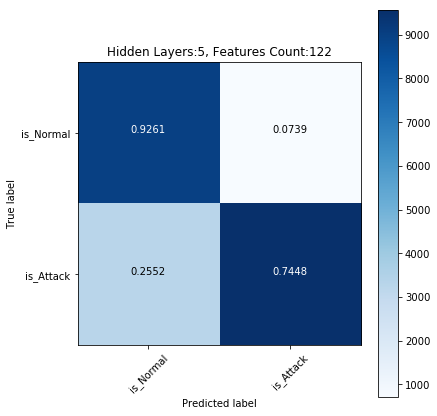

In [14]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Normalized confusion matrix
[[ 0.6668  0.3332]
 [ 0.3355  0.6645]]


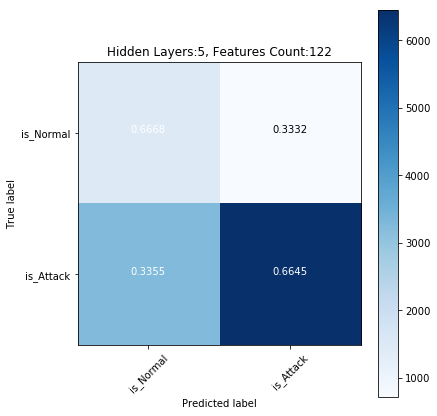

In [15]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [16]:
past_scores

,,epoch,train_score,test_score,test_score_20,time_taken
no_of_features,hidden_layers,,,,,
1,1,30,0.993173,0.798084,0.617384,11.792274
8,1,30,0.985592,0.782026,0.585992,2.908518
32,1,30,0.985473,0.776748,0.576034,11.360495
122,1,30,0.985354,0.775594,0.572827,23.445837
1,3,30,0.992618,0.796620,0.615190,7.470656
8,3,30,0.996229,0.800435,0.620591,55.099488
32,3,30,0.995396,0.786773,0.593755,59.503796
122,3,30,0.987220,0.772756,0.567511,35.854756
1,5,30,0.993888,0.798749,0.618059,21.530259
